In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import os

#from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
import seaborn as sns

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [106]:
data = pd.read_csv('data/Kobe.csv')

In [107]:
data.head(5)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [108]:
target = 'shot_made_flag'

# Summarize data

In [109]:
object_vars=[var for var in data if data[var].dtype=='object']
numerical_vars=[var for var in data if data[var].dtype=='float' or data[var].dtype=='int']
for var in object_vars:
    print(data[var].value_counts())

Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot              

In [110]:
nona =  data[pd.notnull(data['shot_made_flag'])]

Text(0.5, 1.0, 'lat and lon')

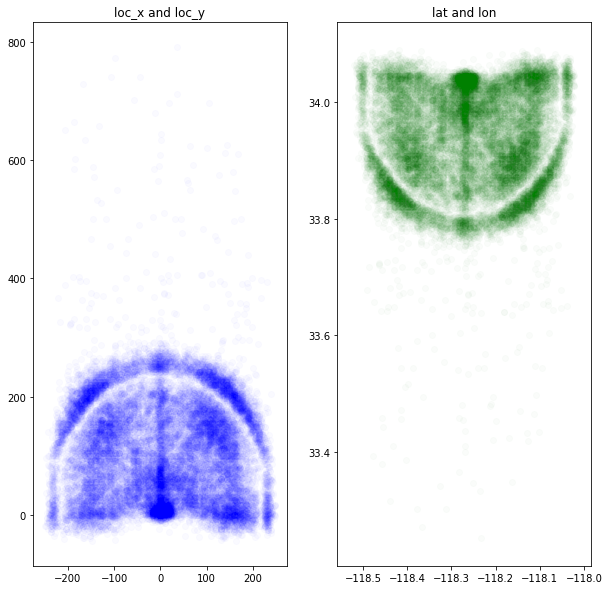

In [111]:
alpha = 0.02
plt.figure(figsize=(10,10))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(nona.loc_x, nona.loc_y, color='blue', alpha=alpha)
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(122)
plt.scatter(nona.lon, nona.lat, color='green', alpha=alpha)
plt.title('lat and lon')

# Добавляем фичу дистанция

In [112]:
nona['dist'] = np.sqrt(nona['loc_x']**2 + nona['loc_y']**2)

loc_x_zero = nona['loc_x'] == 0
nona['angle'] = np.array([0]*len(nona))
nona['angle'][~loc_x_zero] = np.arctan(nona['loc_y'][~loc_x_zero] / nona['loc_x'][~loc_x_zero])
nona['angle'][loc_x_zero] = np.pi / 2 

C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-do


# minutes_remaining and seconds_remaining

In [113]:
nona['remaining_time'] = nona['minutes_remaining'] * 60 + nona['seconds_remaining']

C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [114]:
print(nona.action_type.unique())
print(nona.combined_shot_type.unique())
print(nona.shot_type.unique())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot'
 'Running Hook Shot' 'Alley Oop Dunk Shot' 'Dunk Shot'
 'Alley Oop Layup shot' 'Running Dunk Shot' 'Driving Finger Roll Shot'
 'Running Layup Shot' 'Finger Roll Shot' 'Fadeaway Jump Shot'
 'Follow Up Dunk Shot' 'Hook Shot' 'Turnaround Hook Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Tip Shot'
 'Running Reverse Layup Shot' 'Driving Finger Roll Layup Shot'
 'Fadeaway Bank shot' 'Pullup Jump shot' 'Finger Roll Layup Shot'
 'Turnaround Fadeaway shot' 'Driving Reverse Layup Shot'
 'Driving Slam Dunk Shot' 'Step Back Jump shot' 'Turnaround Bank shot'
 'Reverse Slam Dunk Shot' 'Floating Jump shot' 'Putback Slam Dunk Shot'
 'Running Bank shot' 'Driving Bank shot' 'Driving Jump shot'
 'Putback Layup Shot' 'Putback Dun

# Изменяем фичу сезон

In [115]:
nona['season'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [116]:

nona['season'] = nona['season'].apply(lambda x: int(x.split('-')[1]) )
nona['season'].unique()

C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 97,
       98, 99,  0], dtype=int64)

In [117]:
nona['home']=nona['matchup'].apply(lambda x: 1 if 'vs' in x else 0)
#nona=nona.drop('matchup',axis=1)

C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Ибавляемся от ненужных фичей

Text(0.5, 1.0, 'dist and shot_distance')

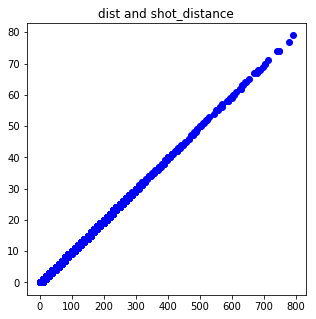

In [118]:
plt.figure(figsize=(5,5))

plt.scatter(nona.dist, nona.shot_distance, color='blue')
plt.title('dist and shot_distance')

team_id','team_name' - тоже не нужны ;
'lon','lat' - коррелированы с oc_x и  loc_y

# Фичи дублируются

# Кластеры бросков

Text(0.5, 1.0, 'shot_zone_range')

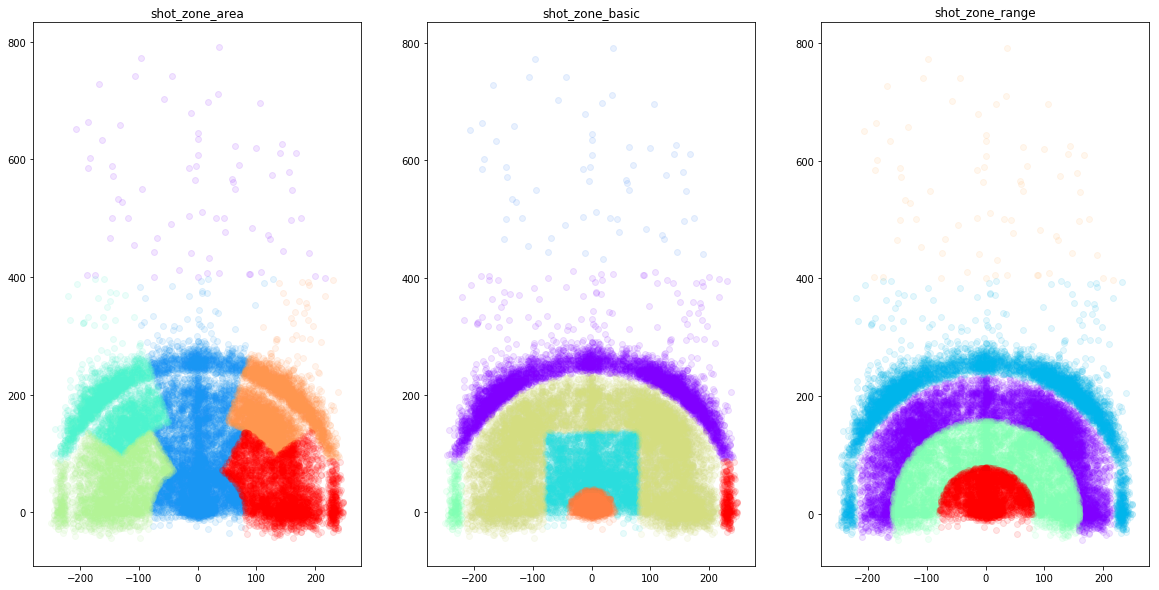

In [119]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = nona.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,team_id,team_name,game_date,matchup,opponent,shot_id,dist,angle,remaining_time,home
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2,157.000000,-0.000000,622,0
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3,168.600119,-0.928481,465,0
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4,222.865430,0.903063,412,0
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5,0.000000,1.570796,379,0
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6,145.416643,0.075717,572,0


# Формируем датасет для обучения и проверки модели

In [216]:
from sklearn.model_selection import train_test_split

In [217]:
nona_s = nona.sample(1000)

In [218]:
nona_s = nona_s.fillna(0)

In [219]:
y = nona_s['shot_made_flag'].copy()

In [220]:
datamart_train, datamart_test, y_train, y_test = train_test_split(nona_s, y, test_size=0.3, random_state=42)

In [221]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [222]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [223]:
    columns_to_get_counts = [
    'action_type',
    'combined_shot_type',
    'shot_type',
        'opponent'
    
    ]

In [224]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']

In [225]:
train_columns = [
    col for col in datamart_train.columns.tolist()
    if col not in set(
drops
    )
]

In [226]:
datamart_train[train_columns].head(3)

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,opponent,dist,angle,remaining_time,home
10541,Layup Shot,Layup,4,0,7,0.0,2PT Field Goal,BOS,19.723083,1.039072,627,0
8911,Jump Shot,Jump Shot,3,0,6,1.0,2PT Field Goal,SAC,168.386460,0.751797,457,1
16587,Jump Shot,Jump Shot,2,0,11,0.0,2PT Field Goal,DEN,179.610690,-0.777524,72,0


In [227]:
    for col_get_prob in columns_to_get_counts:
        datamart_train, datamart_test = get_woe_v1(datamart_train, datamart_test, col_get_prob, "shot_made_flag" )

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000002072F6B6A58>>
Traceback (most recent call last):
  File "C:\Users\rajah\Anaconda3\lib\site-packages\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [228]:
datamart_train[train_columns].head(3)

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,opponent,dist,angle,remaining_time,home
10541,Layup Shot,Layup,4,0,7,0.0,2PT Field Goal,BOS,19.723083,1.039072,627,0
8911,Jump Shot,Jump Shot,3,0,6,1.0,2PT Field Goal,SAC,168.386460,0.751797,457,1
16587,Jump Shot,Jump Shot,2,0,11,0.0,2PT Field Goal,DEN,179.610690,-0.777524,72,0


In [229]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date',
        
            'action_type',
        'combined_shot_type',
        'shot_type'
         ,'opponent'
        ]

In [230]:
train_columns = [
    col for col in datamart_train.columns.tolist()
    if col not in set(
drops
    )
]

In [231]:
train_columns

['period',
 'playoffs',
 'season',
 'shot_made_flag',
 'dist',
 'angle',
 'remaining_time',
 'home',
 'action_type_woe',
 'combined_shot_type_woe',
 'shot_type_woe',
 'opponent_woe']

In [232]:
corr = datamart_train[train_columns].corr()
corr

,period,playoffs,season,shot_made_flag,dist,angle,remaining_time,home,action_type_woe,combined_shot_type_woe,shot_type_woe,opponent_woe
period,1.000000,-0.038546,0.002879,0.005587,0.058851,-0.080405,-0.123589,0.038617,-0.046308,0.013737,-0.101538,0.029961
playoffs,-0.038546,1.000000,-0.034076,0.010521,-0.036971,0.045502,0.071372,0.007000,-0.020285,0.051003,0.040734,-0.050491
season,0.002879,-0.034076,1.000000,0.025758,-0.039236,0.073610,-0.039311,0.007543,0.045892,0.045114,0.008196,0.080879
shot_made_flag,0.005587,0.010521,0.025758,1.000000,-0.158559,0.140519,0.056623,-0.032630,0.266310,0.264203,0.051081,0.203619
dist,0.058851,-0.036971,-0.039236,-0.158559,1.000000,-0.407545,-0.124264,0.012247,-0.462933,-0.504583,-0.664440,-0.085092
angle,-0.080405,0.045502,0.073610,0.140519,-0.407545,1.000000,0.062497,0.036463,0.158450,0.343752,0.181591,-0.008172
remaining_time,-0.123589,0.071372,-0.039311,0.056623,-0.124264,0.062497,1.000000,0.003724,0.034819,0.056377,0.171086,0.000288
home,0.038617,0.007000,0.007543,-0.032630,0.012247,0.036463,0.003724,1.000000,-0.014439,-0.036559,0.035591,-0.015926
action_type_woe,-0.046308,-0.020285,0.045892,0.266310,-0.462933,0.158450,0.034819,-0.014439,1.000000,0.402084,0.270878,0.120161
combined_shot_type_woe,0.013737,0.051003,0.045114,0.264203,-0.504583,0.343752,0.056377,-0.036559,0.402084,1.000000,0.183683,0.067607


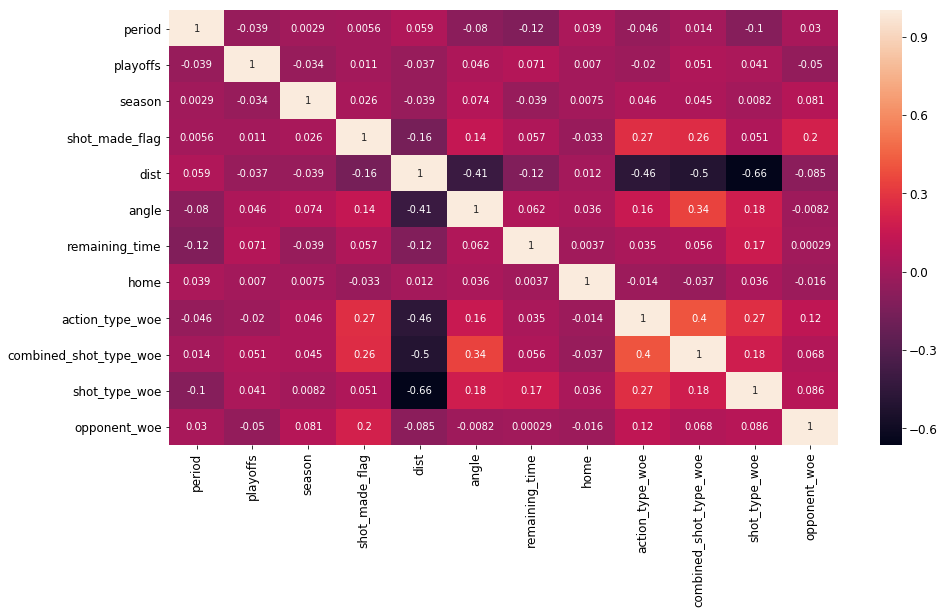

In [233]:
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Функции для трансформации категориальных переменных

In [234]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date',
        
            'action_type',
        'combined_shot_type',
        'shot_type'
         ,'opponent',
         'shot_made_flag'
        ]

In [235]:
train_columns = [
    col for col in datamart_train.columns.tolist()
    if col not in set(
drops
    )
]

In [236]:
train_columns

['period',
 'playoffs',
 'season',
 'dist',
 'angle',
 'remaining_time',
 'home',
 'action_type_woe',
 'combined_shot_type_woe',
 'shot_type_woe',
 'opponent_woe']

In [237]:
x_train = datamart_train[train_columns]
y_train = datamart_train['shot_made_flag']
x_test = datamart_test[train_columns]
y_test = datamart_test['shot_made_flag']

In [238]:
x_train.head(1)

,period,playoffs,season,dist,angle,remaining_time,home,action_type_woe,combined_shot_type_woe,shot_type_woe,opponent_woe
10541,4,0,7,19.723083,1.039072,627,0,-0.193804,0.335714,0.054516,-0.784672


In [239]:
import xgboost
xgb = xgboost.XGBClassifier(max_depth=5)#, n_jobs=-1)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [240]:
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.99
Test:  0.66


# Регрессии


In [241]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

In [242]:
est = smf.ols('shot_made_flag ~ period+playoffs+season+shot_made_flag+dist+angle+remaining_time+home+action_type_woe+combined_shot_type_woe+shot_type_woe+opponent_woe', datamart_train).fit()
est_res = est.summary()
est_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.457e-16,8.07e-16,-0.181,0.857,-1.73e-15,1.44e-15
period,1.093e-16,1.65e-16,0.663,0.508,-2.14e-16,4.33e-16
playoffs,6.939e-18,5.65e-16,0.012,0.990,-1.1e-15,1.12e-15
season,-1.985e-16,8.62e-18,-23.017,0.000,-2.15e-16,-1.82e-16
shot_made_flag,1.0000,4.11e-16,2.43e+15,0.000,1.000,1.000
dist,1.656e-17,3.59e-18,4.608,0.000,9.5e-18,2.36e-17
angle,1.405e-16,2.17e-16,0.647,0.518,-2.86e-16,5.67e-16
remaining_time,3.598e-18,9.44e-19,3.812,0.000,1.74e-18,5.45e-18
home,2.984e-16,3.86e-16,0.774,0.439,-4.59e-16,1.06e-15
action_type_woe,1.013e-15,4.06e-16,2.497,0.013,2.16e-16,1.81e-15


In [243]:
three_x_lm = smf.ols('shot_made_flag ~ period+playoffs+season+shot_made_flag+dist+angle+remaining_time+home+action_type_woe+combined_shot_type_woe+shot_type_woe+opponent_woe', datamart_train).fit()
rss = np.sum(three_x_lm.resid ** 2)
print("RSS:", rss)
print("RSE:", np.sqrt(rss / (datamart_train.shape[0] - 3 - 1)))
print("R^2:", three_x_lm.rsquared)

RSS: 1.5369282521562895e-26
RSE: 4.699181042853095e-15
R^2: 1.0


In [244]:
train_columns

['period',
 'playoffs',
 'season',
 'dist',
 'angle',
 'remaining_time',
 'home',
 'action_type_woe',
 'combined_shot_type_woe',
 'shot_type_woe',
 'opponent_woe']

In [246]:
from sklearn.linear_model import Ridge, Lasso

datamart_train = datamart_train.fillna(0)
datamart_test = datamart_train.fillna(0)

X = datamart_train[train_columns].as_matrix()
y = datamart_train.shot_made_flag

rg = Lasso(alpha=1000, normalize=True, max_iter=1e5).fit(X, y)
print(rg.intercept_)
print(rg.coef_)

rg2 = Ridge(alpha=1000, normalize=True, max_iter=1e5).fit(X, y)
print(rg.intercept_)
print(rg.coef_)


def lasso_regression(data, predictors, alpha, models_to_plot={}):
    # fit
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors], data['shot_made_flag'])
    y_pred = lassoreg.predict(data[predictors])
    
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['shot_made_flag'], y_pred)
        plt.plot(data['shot_made_flag'], data['shot_made_flag'], '.')
        plt.title('Plot for alpha: %.3g' % alpha)
    
    # format
    rss = sum((y_pred-data['shot_made_flag']) ** 2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

0.46714285714285714
[ 0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.]
0.46714285714285714
[ 0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.]


C:\Users\rajah\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной